### 1. Import libraries

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
import jieba
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### 2. Load data and preprocess

In [4]:
def preprocess_text(text):
    words = jieba.cut(text)
    return ' '.join(words)

def convert_sentiment(score):
    if score == -2:
        return 'not_mentioned'
    elif score == -1:
        return 'negative'
    elif score == 0:
        return 'neutral'
    else:  # score == 1
        return 'positive'

def load_and_preprocess_data(file_path):
    df = pd.read_csv(file_path)
    
    # Define aspects, e.g. Food#Appearance, Service#Price, etc.
    aspect_columns = [col for col in df.columns if col not in ['id', 'review', 'star']]
    y = df[aspect_columns]

    # Convert sentiment scores to categorical labels
    y = df[aspect_columns].astype('object')
    for col in y.columns:
        y.loc[:, col] = y[col].apply(convert_sentiment)

    # Data preprocessing
    df['processed_review'] = df['review'].apply(preprocess_text)
    
    return df['processed_review'], y, aspect_columns

train_path = "../data/train.csv"
dev_path = "../data/dev.csv"
test_path = "../data/test.csv"

X_train, y_train, aspect_columns = load_and_preprocess_data(train_path)
X_dev, y_dev, _ = load_and_preprocess_data(dev_path)
X_test, y_test, _ = load_and_preprocess_data(test_path)

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.322 seconds.
Prefix dict has been built successfully.


In [ ]:
print(f"Training data shape: {X_train.shape}, {y_train.shape}\n")

# print example of training data
print("Example of training data:")
for i in range(5):
    print(f"Review: {X_train.iloc[i][:20]}, Labels: {y_train.iloc[i].to_dict()}")

Training data shape: (36850,), (36850, 18)

Example of training data:
Review: 状元 楼 饭店 第一次 去 ， 因为 地, Labels: {'Location#Transportation': 'positive', 'Location#Downtown': 'positive', 'Location#Easy_to_find': 'positive', 'Service#Queue': 'not_mentioned', 'Service#Hospitality': 'positive', 'Service#Parking': 'not_mentioned', 'Service#Timely': 'not_mentioned', 'Price#Level': 'not_mentioned', 'Price#Cost_effective': 'not_mentioned', 'Price#Discount': 'not_mentioned', 'Ambience#Decoration': 'positive', 'Ambience#Noise': 'not_mentioned', 'Ambience#Space': 'not_mentioned', 'Ambience#Sanitary': 'not_mentioned', 'Food#Portion': 'not_mentioned', 'Food#Taste': 'positive', 'Food#Appearance': 'not_mentioned', 'Food#Recommend': 'not_mentioned'}
Review: 我 最 爱 他们 家 的 猪手 ， 麻辣, Labels: {'Location#Transportation': 'positive', 'Location#Downtown': 'not_mentioned', 'Location#Easy_to_find': 'not_mentioned', 'Service#Queue': 'not_mentioned', 'Service#Hospitality': 'positive', 'Service#Parking': 'not_mentioned'

### 3. Exploratory data analysis

In [22]:
# Inline plotting for Jupyter notebooks
%matplotlib inline

In [29]:
def eda(y, dataset_name):
    
# 1. Aspect Mention Frequency
    mention_freq = (y != 'not_mentioned').mean()
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x=mention_freq.index, y=mention_freq.values)
    plt.title(f"Aspect Mention Frequency in {dataset_name} Dataset")
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Proportion of Reviews Mentioning Aspect")
    # Add values on top of bars
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.2f}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', xytext=(0, 5), textcoords='offset points')
    plt.tight_layout()
    plt.show()
    
    # 2. Sentiment Distribution for Each Aspect
    for aspect in y.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=y, x=aspect)
        plt.title(f"Sentiment Distribution for {aspect} in {dataset_name} Dataset")
        plt.xlabel("Sentiment")
        plt.ylabel("Count")
        plt.savefig(f"sentiment_distribution_{aspect}_{dataset_name}.png")
        plt.close()
    
    # 3. Distribution of Number of Aspects Mentioned per Review
    num_aspects_mentioned = (y != 'not_mentioned').sum(axis=1)
    plt.figure(figsize=(10, 6))
    sns.histplot(num_aspects_mentioned, bins=range(0, len(y.columns)+1), kde=False)
    plt.title(f"Distribution of Number of Aspects Mentioned per Review in {dataset_name} Dataset")
    plt.xlabel("Number of Aspects Mentioned")
    plt.ylabel("Number of Reviews")
    plt.savefig(f"num_aspects_mentioned_{dataset_name}.png")
    plt.close()
    
    # 4. Summary Statistics
    print(f"Total reviews: {len(y)}")
    print(f"Number of aspects: {len(y.columns)}")
    avg_mentions = num_aspects_mentioned.mean()
    print(f"Average number of aspects mentioned per review: {avg_mentions:.2f}")

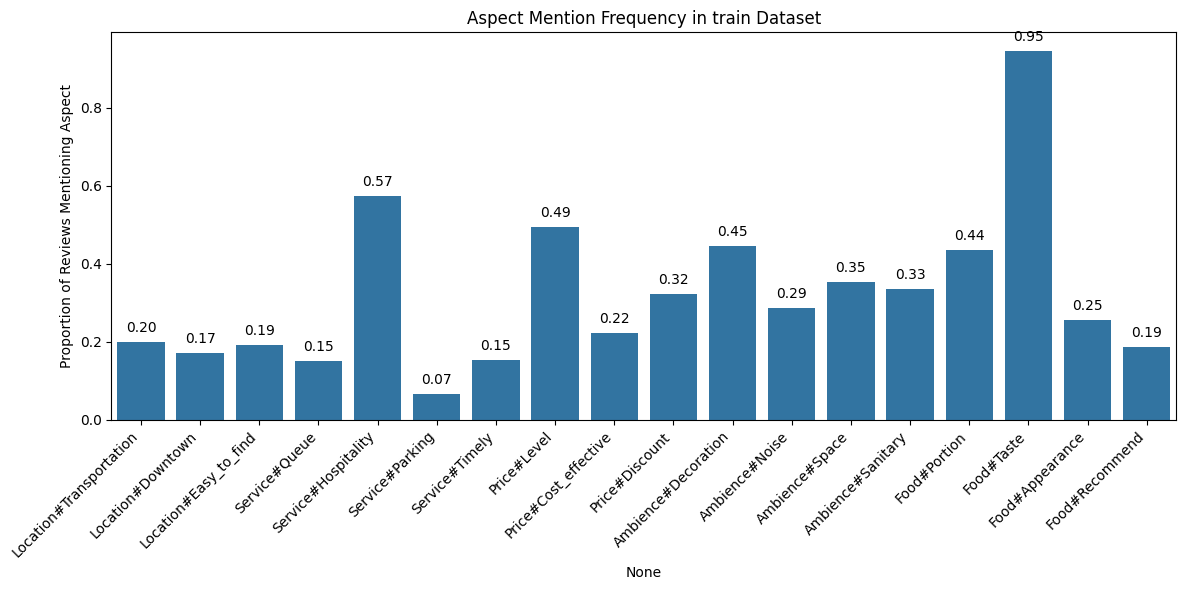

Total reviews: 36850
Number of aspects: 18
Average number of aspects mentioned per review: 5.79


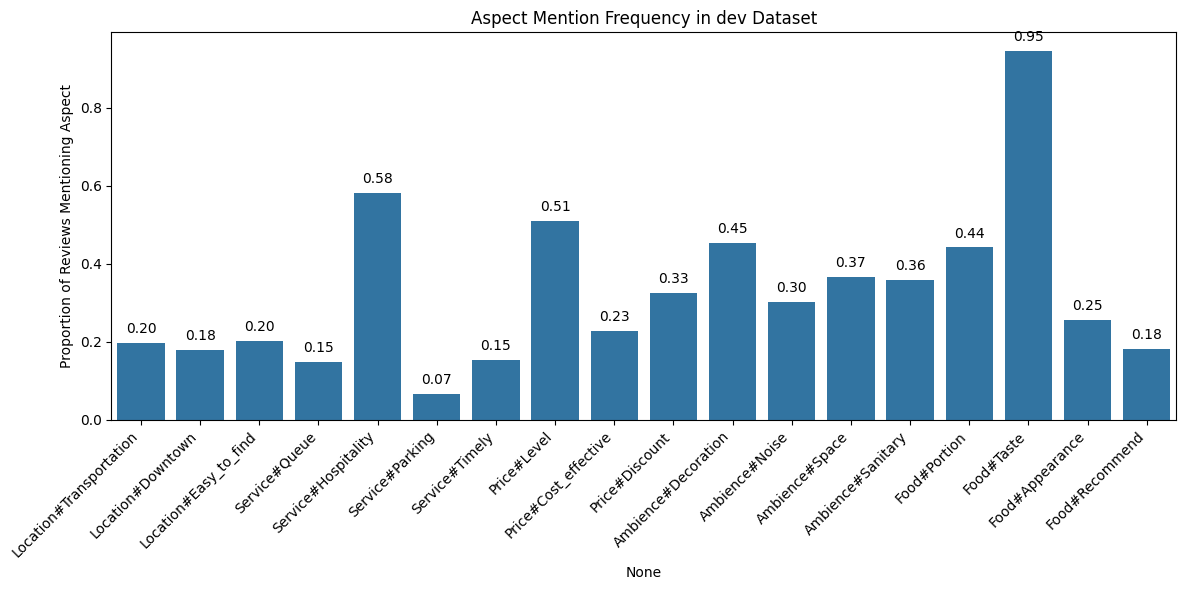

Total reviews: 4940
Number of aspects: 18
Average number of aspects mentioned per review: 5.89


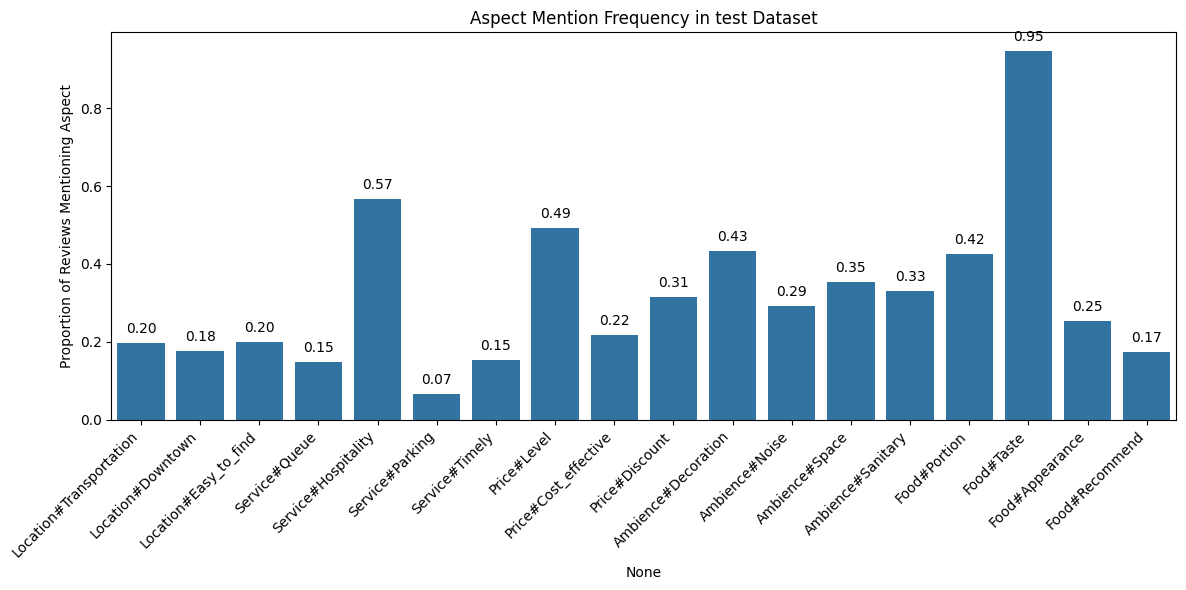

Total reviews: 4940
Number of aspects: 18
Average number of aspects mentioned per review: 5.74


In [30]:
eda(y_train, "train")
eda(y_dev, "dev")
eda(y_test, "test")